In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import scipy

import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools

In [83]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [84]:
def preprocessing(ecg_signal, fs):
    band_pass_filter = scipy.signal.butter(1, [5, 35], btype='bandpass', fs=fs)
    filtered_signal = scipy.signal.filtfilt(band_pass_filter[0], band_pass_filter[1], ecg_signal)
    
    absolute_signal = np.abs(filtered_signal)
    window_length = int(0.05 * fs)
    smoothed_signal = np.convolve(absolute_signal, np.ones(window_length)/window_length, mode='same')
    
    return smoothed_signal


def qrs_localization(h, thresold):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = 0.15 * max(h[:w])
    for i in range(len(h)):
        if i%w == 0 and i != 0:
            threshold = 0.15 * max(h[i-(w//2):i+(w//2)])
        #print(h[i])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= 36: # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

In [85]:
"""df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)[:30000]
fs = 360
ecg_signal = ecg_signal - np.mean(ecg_signal)
print_signal(ecg_signal, "origin")
preprocessed_signal = preprocess_ecg(ecg_signal, fs)
print_signal(preprocessed_signal, "preprocessed")"""

'df = pd.read_csv(\'data_csv/mit_bih_Arrhythmia/207.csv\') #207\necg_signal = np.array(df["MLII"], dtype=np.float32)[:30000]\nfs = 360\necg_signal = ecg_signal - np.mean(ecg_signal)\nprint_signal(ecg_signal, "origin")\npreprocessed_signal = preprocess_ecg(ecg_signal, fs)\nprint_signal(preprocessed_signal, "preprocessed")'

In [86]:
def qrs_detector_5(signal, seuil = 0, delay = 0):
    if seuil == 0:
        seuil = max(signal) / 6
    if delay == 0: 
        delay = 36
    i = 0
    peak_position = []
    peak_amplitude = []
    sous_groupe = []
    while i < len(signal):
        if signal[i]>= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= delay:
            max_value = max((signal[j], j) for j in sous_groupe)
            peak_amplitude.append(max_value[0])
            peak_position.append(max_value[1])
            #peak.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
            i += int(fs*0.28) # interval minimum donné dans l'article
        i += 1
    if sous_groupe != []:
        max_value = max((signal[j], j) for j in sous_groupe)
        peak_amplitude.append(max_value[0])
        peak_position.append(max_value[1])
    return peak_position, peak_amplitude

In [87]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
sampling_rate = 360
maxi = len(df) #10000 #
mini = 0
signal = np.array(df["MLII"], dtype=np.float32)
ecg_signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R) for R in QRS if R <= maxi and R >= mini]

clean_signal = preprocessing(ecg_signal, fs)
L, P = qrs_detector_5(clean_signal)
#print(L)
T = sum(P) / len(P) 

signal de longueur: 650000


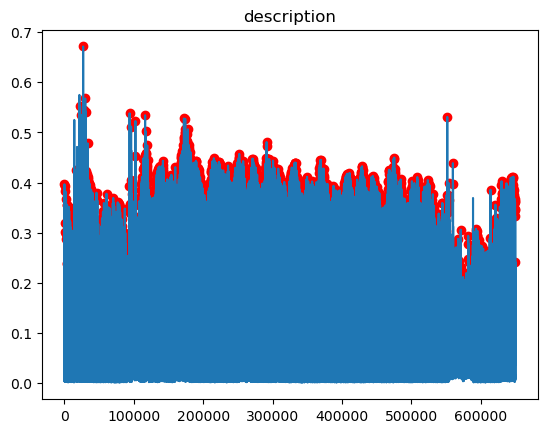

In [88]:
print_signal_qrs(clean_signal, "description", L)

In [89]:
perf(QRS, L, 36)

(1992,
 48,
 390,
 [array([9]),
  array([13868]),
  array([13967]),
  array([14007]),
  array([14263]),
  array([14414]),
  array([14766]),
  array([15018]),
  array([15258]),
  array([15519]),
  array([15759]),
  array([15810]),
  array([15906]),
  array([15951]),
  array([16015]),
  array([16262]),
  array([16383]),
  array([16611]),
  array([16658]),
  array([16710]),
  array([16936]),
  array([17346]),
  array([17396]),
  array([17509]),
  array([17618]),
  array([17669]),
  array([17730]),
  array([17857]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([19964]),
  array([20183]),
  array([20297]),
  array([20402]),
  array([20521]),
  array([20748]),
  array([20962]),
  array([21047]),
  array([21092]),
  array([21183]),
  array([21432]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22513]),
  array([22774]),
  array([25627]),
  array([27256]),
  array([29115]),
  array([48133]),
  array([74943]),
  array([86540]),
  array([87172

In [90]:
def make_B_i(H, fs, i):
    return (60 * fs) / (H[i+1] - H[i])

def make_Bw(B_i, Q, H):
    return 1.75 * sum([make_B_i(H, fs, i) for i in range(3, Q-1)]) / (Q - 4) 

def make_vsl(a, vsl):
    return a * 0.1 + 0.9 * Vsl

def make_vnl(a, vnl):
    return 0.2 * a + 0.8 * vnl

def make_M(Vnl, Vsl):
    return 0.6 * Vnl + (0.6 * (Vsl - Vnl))

def divide_into_segments(G, H, C):
    G_segments = [G[i:i+C] for i in range(0, len(G), C)]
    H_segments = [H[i:i+C] for i in range(0, len(H), C)]
    return G_segments, H_segments

def make_Dfp(Y):
    return [Y[x] - Y[x-1] for x in range(1, len(Y))]

In [104]:
M = T.copy()
R = T * 0.6

Vsl = M
Vnl = R

Bw = 0

i = 0
H = [] #L[:4]
G = [] #P[:4]
B_i = 0
while i < len(P):
    if P[i] >= M:
        G.append(P[i])
        H.append(L[i])
        Vsl = make_vsl(P[i] , Vsl)

    elif P[i] < M and P[i] >= R:
        B_i = make_B_i(H, fs, len(H)-2)
        Bw = make_Bw(B_i, len(H)-1, H)

        if B_i <= Bw:
            G.append(P[i])
            H.append(L[i])
            Vsl = make_vsl(P[i] , Vsl) 
        else:
            Vnl = make_vnl(P[i], Vnl)
            
    M = make_M(Vnl, Vsl)
    R = M/2
    i += 1

In [79]:
# Y = location, Z = puissance
# division en taille max 50 000
C = 50000
G_seg, H_seg = divide_into_segments(G, H, C)
y = []
i = 1
while i < len(G_seg):
    Y = H_seg[i]
    Z = G_seg[i]
    F = 0.8 * sum(Z) / C
    Dfp = make_Dfp(Y)
    k = 0.75 # à voir
    W = k * sum(Dfp) / len(Dfp)
    for j in Z[1:]:
        if j < F and Dfp[j-1] < W and Dfp[j] < W:
            Y.pop(j)
            Z.pop(j)
    i += 1
A = [element for sous_liste in H_seg for element in H_seg][0]
E = [element for sous_liste in H_seg for element in G_seg][0]

In [80]:
Dsb =  [A[x] - A[x-1] for x in range(1, len(A))]
S = 1.75 * sum(Dsb) / len(Dsb)
n = 1
Q = len(Dsb)
final_peaks = []
while n < Q:
    if Dsb[n] >= S:
        sub_signal = clean_signal[A[n]:A[n+1]+1]
        M_local = max(sub_signal) * 0.25
        f = qrs_detector_5(sub_signal, seuil = M_local, delay = S/2)
        final_peaks.append(f)
    final_peaks.append(A[n])
    n += 1

In [81]:
perf(QRS, A, 36)

(1976,
 42,
 406,
 [array([9]),
  array([13868]),
  array([13967]),
  array([14263]),
  array([14414]),
  array([14766]),
  array([14894]),
  array([15138]),
  array([15387]),
  array([15519]),
  array([15759]),
  array([16015]),
  array([16262]),
  array([16496]),
  array([16710]),
  array([16936]),
  array([17346]),
  array([17396]),
  array([17509]),
  array([17618]),
  array([17669]),
  array([17730]),
  array([17976]),
  array([18081]),
  array([18132]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([19964]),
  array([20183]),
  array([20297]),
  array([20402]),
  array([20521]),
  array([20748]),
  array([20962]),
  array([21047]),
  array([21092]),
  array([21183]),
  array([21432]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22513]),
  array([22774]),
  array([25627]),
  array([27256]),
  array([29115]),
  array([48133]),
  array([73494]),
  array([74943]),
  array([86540]),
  array([87172]),
  array([87214]),
  array([87403

In [5]:
def print_signal(signal, description):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    #plt.scatter(QRS, [signal[i] for i in QRS], color='red')
    plt.title(label= description)
    plt.show()
    
def print_signal_qrs(signal, description, qrs):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.scatter(qrs, [signal[i] for i in qrs], color='red')
    plt.title(label= description)
    plt.show()
    
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

In [6]:
def extend_list_with_averages(input_list):
    extended_list = [input_list[0]]
    length = len(input_list)

    for i in range(length - 1):
        current_element = input_list[i]
        next_element = input_list[i + 1]
        average = (current_element + next_element) / 2
        extended_list.append(average)
        extended_list.append(next_element)

    return extended_list

In [65]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
maxi = len(df)
mini = 0
signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

[    58    306    842 ... 649598 649794 649992]
signal de longueur: 649999


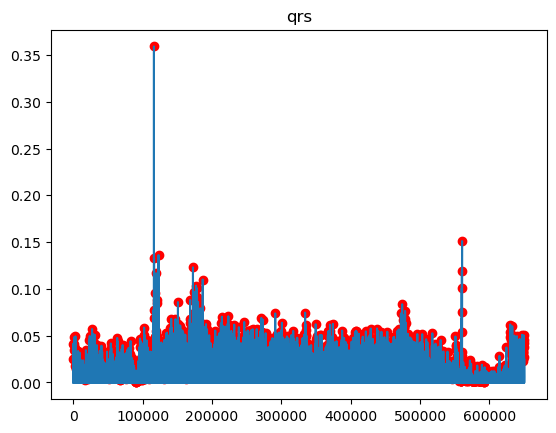

In [70]:
h = wavelet_decomposition(signal, 5)
#print_signal(d4, "wavelets")
#print_signal(d5, "wavelets")
h = extend_list_with_averages(h)
#print_signal(h, "PI")
threshold = 0.2 * max(h)
qrs = np.array(qrs_localization(h, threshold))
print(str(qrs))
qrs.sort()
qrs = delete_contraction(qrs, sampling_rate)
print_signal_qrs(h, "qrs", qrs)

In [73]:
perf(QRS, qrs, 36)
# 2087,  117,  249,

(2135,
 155,
 231,
 [array([9]),
  array([13868]),
  array([14414]),
  array([14754]),
  array([15118, 15138, 15162]),
  array([15759]),
  array([15798]),
  array([16138]),
  array([17346]),
  array([17406]),
  array([17470]),
  array([17618]),
  array([17658]),
  array([17730]),
  array([17788]),
  array([17857]),
  array([17914]),
  array([17976]),
  array([18068]),
  array([18132]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([20168, 20183, 20218]),
  array([20962]),
  array([21056]),
  array([21092]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22774]),
  array([25627]),
  array([27256]),
  array([46025]),
  array([48133]),
  array([55103]),
  array([55775]),
  array([64967]),
  array([65681]),
  array([66375]),
  array([69978]),
  array([71340]),
  array([73494]),
  array([74943]),
  array([83557]),
  array([86540]),
  array([87172]),
  array([87214]),
  array([88202]),
  array([88259]),
  array([88716]),
  array([88788]),
  a

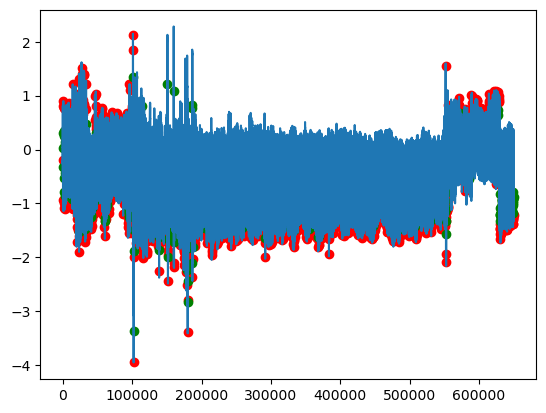

In [60]:
plt.figure()
plt.plot(signal[:maxi])
qrs = [x * 2 for x in qrs]
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

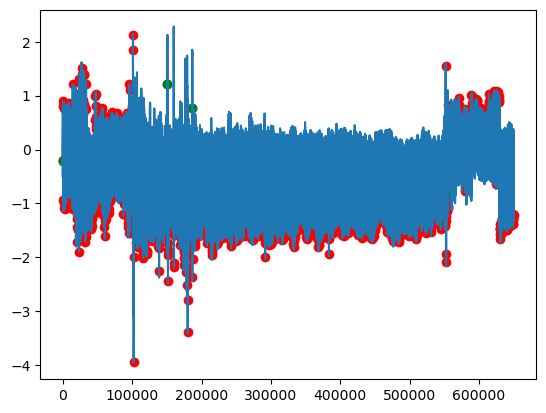

In [16]:
plt.figure()
plt.plot(signal[:maxi])
qrs = qrs*2
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

In [67]:
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

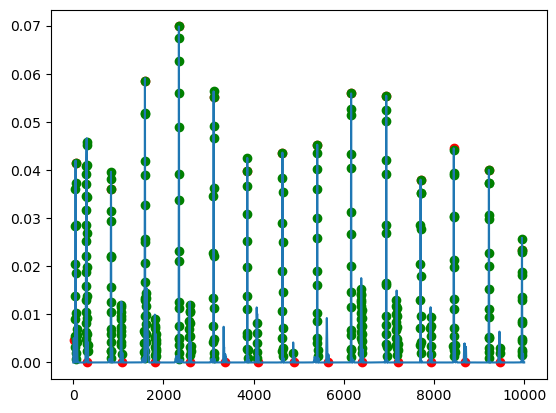

In [34]:
plt.figure()
plt.plot(filtered_signal[:max])
plt.scatter(QRS, [filtered_signal[i] for i in QRS], color='red')
plt.scatter(r_peaks, [filtered_signal[i] for i in r_peaks], color='green')
plt.show()